# Fire Image Classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Keras Imports
import tensorflow as tf
import keras
from keras import backend as K
# CNN and MLP architecture
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Dropout,
    Flatten,
    BatchNormalization
)
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import RandomNormal
# Keras Callbacks
from keras.callbacks import EarlyStopping, TensorBoard
# Time Training
import time
# Data Splitting
from sklearn.model_selection import train_test_split
# Image Preprocessing
from PIL import Image
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


## Get the Data

In [2]:
df = pd.read_csv('Fire-Detection-Image-Dataset/fires.csv')

In [3]:
df.head()

,Unnamed: 0,Folder,filename,label
0,0,Normal Images 3,Hotel_Monterey_La_Soeur_Osaka_standard_twin_be...,0
1,1,Normal Images 3,house5.jpg,0
2,2,Normal Images 3,mi-plage-hawai.jpg,0
3,3,Normal Images 3,JB224_03_Colourful_christmas_table_setting_in_...,0
4,4,Normal Images 3,Interior Design Ideas (3).jpg,0


In [4]:
# define predictor and target sets of data
features = [df.columns[1], df.columns[2]]
target = [df.columns[3]]
X, y = df[features], df[target]
# Store number of class
num_classes = 2

## Split DataFrame Based on Label

In [5]:
# Split df into train and test, based on label
# Credit goes to this Stack Overflow answer for the following:
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
selector = np.random.rand(len(df)) < 0.75
df_train, df_test = df[selector], df[~selector]
print(f"Number of Training Samples: {len(df_train)}")
print(f"Number of Testing Samples: {len(df_test)}")

Number of Training Samples: 494
Number of Testing Samples: 157


## Defining the Optimal Model 

### Build a Generator

For this dataset, we'll increase the efficiency of training by loading in subsections of the dataset to train on at a time, using Python-esque generator in Keras!

In [6]:
def data_gen(df_gen, batch_size):
    """Generate batches of the dataset to train the model on, one subsection at a time.
       Credit goes to Milad Toutounchian for this implementation, originally found at:
       https://github.com/Make-School-Courses/DS-2.2-Deep-Learning/blob/master/Final_Project/image_data_prep.ipynb
    
       Parameters:
       df(DataFrame): larger portion of the datset used for training
       batch_size(int): the number of samples to include in each batch
       
       Returns:
       tuple: input features of the batch, along with corresponding labels
    
    """
    while True:
        # list of images
        x_batch = np.zeros((batch_size, 1024, 1024, 3))
        # list of labels
        y_batch = np.zeros((batch_size, 1))
        # add samples until we reach batch size
        for j in range(len(df_gen) // batch_size):
            batch_index = 0
            for index, image_file, label in zip(df_gen['Unnamed: 0'],
                                                df_gen['filename'].values[j*batch_size:(j+1)*batch_size], 
                                                df_gen['label'].values[j*batch_size:(j+1)*batch_size]):
                print(f'index: {index}, image file: {image_file}')
                filepath = f"Fire-Detection-Image-Dataset/{df_gen['Folder'][index]}/{df_gen['filename'][index]}"
                print(f'File: {filepath}')
                img = Image.open(filepath)
                plt.imshow(img)
                image_red = img.resize((1024, 1024))
                x_batch[batch_index] = img_to_array(image_red)
                y_batch[batch_index] = label
                batch_index += 1
            yield (x_batch, y_batch)

### Finding the Best Architecture

Now we'll find the optimal number of layers and neurons per layer using TensorBoard.

In [7]:
# Helper functions to Reduce Repetition of Adding Layers
def add_conv_layer(model, layer_size, needs_input):
    """Add a Keras convolutional layer to the model, along with MaxPooling.
       Will specify input shape as well if needed.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       need_input(bool): signals if the convolutional layer needs to specify
                         the dimensions of the input
       
       Returns: None
       
    """
    if needs_input is True:
        # specify input dimension for 1st conv layer
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(1024, 1024, 3))

    else:
        # otherwise all other convolutional layers don't need it
        conv_layer = Conv2D(layer_size,
                            kernel_size=(3, 3),
                            activation='relu')
    # add Convolutional layer
    model.add(conv_layer)  
    # add MaxPooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  # no learning params
    return None
                  
    
def add_dense_layer(model, layer_size, is_output):
    """Add a multi-layer perceptron to the model
       Will specify 'sigmoid' for the final layer.
       
       Parameters:
       model(Model): Neural network in Keras
       layer_size(int): number of neurons to go in layer
       is_output(bool): signals if the MLP is the last layer
       
       Returns: None
       
    """
    # specify activation function
    activation = 'relu' if is_output is False else 'sigmoid'
    # add MLP
    model.add(Dense(layer_size, activation=activation))         
    return None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



index: 5, image file: meeting.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 0, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 6, image file: Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
Epoch 1/5
index: 18, image file: LimeLightsDallas.812.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Light-wood-white-interior.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wo

index: 64, image file: mps-conv-store-model2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 0, image file: Kristiansund_Atlanticrd_740.jpgindex: 71, image file: Picture-014.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg

File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 77, image file: open-offices.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: shopping_large.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: xsylvia-hotel-queen-room.jpg.pagespeed.ic.hw9Tgtz7QM.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: rooms-image-small.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: Sm

index: 21, image file: fireplace-with-no-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 3, image file: hotel-continental-marienbad-room-standard-10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 30, image file: crystal-cave-8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: bangkok-airport3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 4, image file: modern-living-room-with-TV-Neopolis.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Hot-in-Cleveland-house-at-night-front.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 38, image file: Carson-City-Retail-Interior-Design1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg


index: 100, image file: 12.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: 2014-01-21-RTKLLONDON.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: article-2018976-0D29840100000578-237_634x384.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: 4edcf7037ce106b5bc300f99ef671a91_936_425.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: 0921231903.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: 20160711044639758.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: 4551643-interior-of-the-modern-conference-hall.jpg
File: Fire-Detection-Image-

index: 92, image file: fire1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 9, image file: norway-landscape-photography-scandinavian-nature-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: New-Natural-Waterfall-HD-Wallpaper-Collection-2013-For-PC-4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: quilotoa.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: oslo-city.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: Problem-smoke-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: nord.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Multipurpose-home-office-design-with-unique-table-and-quartz-countertop.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsf

index: 22, image file: theoffice3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: tumblr_nhcrcizCaH1ty53xvo1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 38, image file: norway___view_of_the_geiranger_by_agivega.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: oslo t07.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 24, image file: y5IQiH.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 63, image file: normal-home-living-room-denbesten-real-estate-bloomington-rooms-1602-bensington-master-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 25, image 

index: 0, image file: Romsdalsfjorden-rundt_lightbox_full_screen.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 99, image file: autumn-sunset-sky.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: Conference_Room_CHENG_Ze.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: csm_Norwegen-Slider-1-WEB_481d92d85e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: black-and-beige-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: fire-featured.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Beautiful-Morrocan-st

index: 17, image file: throstur-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: slide-201512-norway-06.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: sunset_by_koko_stock-d5ls8sf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: room1212.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: virgo-esb-liberty-meeting-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 0, image file: salle-de-bains-amenagement-69157893.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Rent room stockholm.jpg
File: Fire-Detection-Image-Dataset/Normal Ima

index: 12, image file: CCTV-in-supermarket.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: cool-home-office-ideas-and-get-inspired-to-redecorate-your-Home-Office-with-these-decorative-Home-Office-ideas-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: DSCN1146-600x350.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: ce17da98fd0525cbe7ea1816b90fe4d9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Gingerbread_House_Essex_CT.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: canvas-press_custom-wallpaper_conference_room.jpg
File: Fire-Detection-Image-Dat

index: 4, image file: Feng-Shui-your-Bedroom-98135424-web.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Athens-International-Airport.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: atlantic-ocean-road62.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: Gullivers-0840-small-8c1235a8.png
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: Birds Nest.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: attachment-image-1cfe3cc1-a2b6-402c-a50e-8436e4f7f3c2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: c77e354d46f7e8cc7babe8fdf8f93c76.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: city_streets2_800.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 

index: 25, image file: 24551b883de1686d35e953d43312dedf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 0, image file: 8f4eaec213662be924ae9e7a99d20b11.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 700c959d9d4a1ae442592fceac6cb42eb915eca669fbd988bce10911a32f6253.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: 5983c29594905fdd0be9d691c036c90b0603f68d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 98314964.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: 385Springwater Trailer Resort.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 98282906.jpg
File: Fire-Detection-Image-

index: 17, image file: 4205c7bf872ff65b5569a54616e7fc4b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 1200_ded3cdcfdca66b2fc57ee8d9bbc6c827.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: article-2561466-1BE9F3FA00000578-681_634x415.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: article-1389742-0E432C8C00000578-832_634x436.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 9/24 [==========>...................] - ETA: 2:27 - loss: 0.5257 - accuracy: 0.9389 - precision: 0.0000e+00 - recall: 0.0000e+00index: 0, image file: 175822886.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/H

index: 12, image file: dsc7056.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: nederland-fire-12.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 450047458.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: rs-237211-GettyImages-53372022.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: pic1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: tree-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: wildfire1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-S

index: 3, image file: Lake-Edward.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Late_model_Ford_Model_T.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Meeting room with people2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: living-room-large-big-interior-design-2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: llanelli-fire-red-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: JEs238e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: maxresdefault343.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: messy-office-space.jpg
File: Fire-Detection-Image-Dataset/Normal Ima

index: 24, image file: QzOffice-750x400-c-default.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: north-norway-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
17/24 [====================>.........] - ETA: 1:09 - loss: 139.4238 - accuracy: 0.8853 - precision: 0.2385 - recall: 0.1887index: 0, image file: officedsdg.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: o-BRIGHT-LIGHTING-ROOM-LAMP-facebook.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: office-cctv-cameras-400x2661.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: norway-school-trips-geirangerfjord-vn.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
inde

index: 14, image file: Sunset-Sky.png
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: SverreHjornevik-FjordNorway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Vardasen-House-13-850x1190.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: Standard-single-1600x900.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: W020160510630506554070.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Tromso.-Photo-credits-Bard-Loken-Innovatioin-Norway-e1397066188664.jpg
File: Fire-Det

index: 4, image file: thumb2-ledjanaja-pewera-reka-led-vechnye-ldy.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: room6_450_reload.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: tumblr_inline_nj85l1oMaC1t5js1c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: SlackOffice1-640x427.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: roros-town-street_2015.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: wallpapers_1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: W1siZiIsInVwbG9hZHMvcGxhY2VfaW1hZ2VzL2YyNzI0MDQyMTM2NjFlYzUxNl8xNTAzMjAxNDQzODcuanBnIl0sWyJwIiwidGh1bWIiLCJ4MzkwPiJdLFsicCIsImNvbnZlcnQiLCItcXVhbGl0eSA5MSAtYXV0by1vcmllbnQiXV0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, i

index: 99, image file: amsterdam_canal_houses_at_night_by_busterbrownbb-d5g1z9c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: 12.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: 2014-01-21-RTKLLONDON.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: article-2018976-0D29840100000578-237_634x384.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: 4edcf7037ce106b5bc300f99ef671a91_936_425.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: 0921231903.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: 20160711044639758.jpg
File: Fire-Dete

index: 90, image file: pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: office3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 99, image file: MW-AU747_wolf_t_20120924164002_MG.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: norway-fjord-beautiful.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: pexels-photo-41118.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299

index: 5, image file: csm_Norwegen-Slider-1-WEB_481d92d85e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 11, image file: Bold-Red-Colors-Decoration-in-Modern-Teen-Bedrooms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 6, image file: black-and-beige-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 12, image file: CCTV-in-supermarket.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: cool-home-office-ideas-and-get-inspired-to-redecorate-your-Home-Office-with-these-decorative-Home-Office-ideas-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 18, image file: fire-featured.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Beautiful-Morrocan-style-for-bedroom-design-2-530x424.jpg
File: Fire-Detection-I

index: 1, image file: ballroom2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: GGBR02024A.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: best_western_mornington_hotel_london.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: bn-0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: homeland-stavanger-wooden.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: b4d7b6e907c47ebb74058bac9d1953f1d138cb43b660420e4e42037915b11720.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: Gift_Shop_52.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: gazebo1.jpg
File: Fire-Detection-Image-Dataset/Normal Im

index: 22, image file: 82143-erYd3aYdaDFXh_ff3VC9MA.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 63dff179cc922e5f20ace4ec44e445f4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: 20150930-Einzelzimmer.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: a-fairly-typical-open-office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 5/24 [=====>........................] - ETA: 2:58 - loss: 451.3235 - accuracy: 0.8000 - precision: 0.7713 - recall: 0.9188index: 0, image file: 158.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 1411579788990_wps_176_Pictures_by_Pal_Jakobsen_.jpg
File: Fire-Detection-Image-

index: 12, image file: 873860-winter-in-voss-norway.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 095728210-b1281187-105e-40db-8fff-2f2d5091110a.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 7875419_4_z.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 2016-Ford-Mustang-GT-burnout-red-tire-smoke.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 435bfd95-3be2-4be0-b909-36e5e607078b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: 041212_BIZ_Hook_Logic_MRM_03_display.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg

index: 4, image file: maxresdefault6.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 8679c62af3-lavvuliv.jpg-for-web-normal.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: _91753989_capture.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: House-Fire-3-Odegard.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: Still1115_00000_1479245056445_7039374_ver1.0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: hqdefault.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Fire-in-a-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: bus-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: fire.jpg
File: Fire-Detection-Image-Dataset/N

13/24 [===============>..............] - ETA: 1:46 - loss: 179.2610 - accuracy: 0.8923 - precision: 0.7737 - recall: 0.9153index: 0, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: house5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: mi-plage-hawai.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Interior Design Ideas (3).jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: large-meeting-

index: 16, image file: Lofoten-Norway-Northern-Lights-13.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: interior-design-living-room-unique-with-images-of-interior-design-exterior-in-ideas.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: images.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: image.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: moving-green-mountains.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: norway_streets.jpg
File: F

index: 8, image file: New-York-Automobile-Show.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: polycom-conference-room-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: norway-northern-lights.jpg.adapt.945.1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: Norway-Troms-Tromso-Panorama-view.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Perfect-Red-And-Gold-Rooms-45-With-Additional-with-Red-And-Gold-Rooms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: norway-gamle-bergen-museum.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: office-conference-room-design-ideas_354725.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: p9200593.jpg
File: Fire-Detection-Image-Dataset/Nor

21/24 [=========================>....] - ETA: 28s - loss: 110.9711 - accuracy: 0.9333 - precision: 0.7932 - recall: 0.9189index: 0, image file: room_image3324.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: unnamed.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: visionneuse7.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: working-in-office.png
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Wesleyan_University_-_Russell_House_at_night_01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Warm-Bedroom-Design-590x420.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: ver

index: 16, image file: G044.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: cdnassets.hw.net.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: fe4d6738c20d6063f34637ed6b56228e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: DSC5740_HDR-blog-1600px.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: ES_execconfroom_6_712x342_FitToBoxSmallDimension_Center.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: Business-Meeting-Etiquette.jpg
File: Fire-Det

index: 63, image file: How-to-Set-a-Living-Room-on-Fire-with-VFX-in-4K.Still002.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: 25A072C400000578-2951223-image-a-15_1423799067621.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: IMG00256.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: burning-charcoal-briquettes-closeup-14552988.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: 201307-restroom-fire-safety-fire1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: d00cc0fe53897ff01f30eba713ac8ef0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: image1609390x.jpg
File: Fire-Detection-Image-Dataset

index: 21, image file: typical-desk-setup.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: up5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
24/24 [==============================] - 246s 10s/step - loss: 97.0997 - accuracy: 0.9417 - precision: 0.8010 - recall: 0.9214 - val_loss: 209.0279 - val_accuracy: 0.5500 - val_precision: 0.8277 - val_recall: 0.9451
Epoch 3/5
index: 0, image file: B_Id_225951_norway.jpgindex: 36, image file: sunset-palms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg

File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: w300x200.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: Scandic-Grimstad-Exterior-facade001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image fil

 1/24 [>.............................] - ETA: 4:09 - loss: 437.3419 - accuracy: 0.0000e+00 - precision: 0.7870 - recall: 0.9478index: 0, image file: gallery-1428596092-home-sweet-home-living-room-0515.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: f16-small-meeting-roompost.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: f0e56866db7a2b2b7ce8fb1c6fa9a6c1bf6d951b443cec372c0f7fed6bbdb947.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: Hero_O365ForBusiness_1920x560.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: grimstad gaagate 02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: e389ecba7de8e3645ee346d3d19703b6.j

index: 16, image file: darcy434_largeimage.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: En-Route-Stuck-with-a-Cancelled-Flight-in-Hong-Kong-International-Airport-9426.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Christmas-shopping-at-Roros-norway_4df73061-0f32-4f3f-8d35-0f88fa121632.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: california-palm.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: efe.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, i

index: 7, image file: 98282906.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: 360px-Greenmountains.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: 3028310B00000578-3398915-image-a-2_1452764691811.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 080417_4706.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 9544.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: 952111662014LEUDLAV.jpg.png
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 1444.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 45d893bb4a9e15e3ea7aab81ec783e7c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 156ddbd4bb2536343afe883a9ad11b5d.jpg
File: Fire-Detection

 9/24 [==========>...................] - ETA: 2:31 - loss: 48.5935 - accuracy: 0.8889 - precision: 0.7870 - recall: 0.9478index: 0, image file: 175822886.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 400c4254c626f0c30cdac33547ec8693_original.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: 2012-ferarri-f12-berlinetta.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 111052980.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: 723438-norway-memorial.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 45a4925c6329b15ac6184c868b78db14.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8,

index: 22, image file: wildfire1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 4174776173_e8c26989cc_z.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: wildfire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: burning-hause-1535712.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
12/24 [==============>...............] - ETA: 2:03 - loss: 41.3724 - accuracy: 0.8833 - precision: 0.7874 - recall: 0.9462index: 0, image file: burning-house2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: aggiecrk-wildfire-07072015-usfs-580.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image

index: 11, image file: maxresdefault343.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: messy-office-space.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: image3tffh.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: lighting-in-interior-design-interior-home-lighting-lovely-for-your-interior-design-of-bedrooms-ideas.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: house-with-lights-on.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Lofoten-800px-Raftsundet_from_Raftsund_Bridge_2010_September.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701

index: 1, image file: o-BRIGHT-LIGHTING-ROOM-LAMP-facebook.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: office-cctv-cameras-400x2661.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: norway-school-trips-geirangerfjord-vn.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Office-Space-Photo-Open-Design.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: New Picture (26).jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: plot-projects-overview-big_image_url-1403254458.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: norway-landscape-photography-scandinavian-nature-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34

index: 22, image file: W020160510630506554070.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Tromso.-Photo-credits-Bard-Loken-Innovatioin-Norway-e1397066188664.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: ThinkstockPhotos-505230568-540x359.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: warm-tech-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
20/24 [========================>.....] - ETA: 39s - loss: 24.8234 - accuracy: 0.9300 - precision: 0.7970 - recall: 0.9458index: 0, image file: Romsdalsfjorden-rundt_lightbox_full_screen.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Supermar

index: 14, image file: day7_8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: deluxe-room-01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: atlantic-road-norway-6.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: doc_14_4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Haikou Mingguang hotel_deluxe room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Bodoe_aug2010x17.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Tr

index: 30, image file: 906a126cd675836e17f24837ff7ade1b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: 8471644323_90981b7693.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: ask-history-who-built-the-first-automobile-464493489-E.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: 9129708.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: 289259543-business-meeting-salle-de-conference-discuter-debattre-collegues.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: Amanda Aitken Article Image 2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: 2-640x400.jpg
File: Fire-Detection-Image-Dataset/Norm

index: 19, image file: office-9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: open-plan-office-with-people.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: Open-plan-office-2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: PriceLake.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: Narita_International_Airport_Terminal_2_counters_(1).JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: norway___view_of_the_geiranger_by_agivega.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: oslo t07.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: normal-home-living-room-denbesten-real-estate-bloomington-rooms-1602-bensing

index: 15, image file: ce17da98fd0525cbe7ea1816b90fe4d9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 20, image file: dark-red-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 16, image file: Gingerbread_House_Essex_CT.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 21, image file: fireplace-with-no-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 17, image file: canvas-press_custom-wallpaper_conference_room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 30, image file: crystal-cave-8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 22, image file: Elagant-Office-Me

index: 14, image file: conference-room2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: CM1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: b33375c5ff1a2f222ebdca2b0046eecc.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: e3d93d96e76e00a0c1df99a94f33c921.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Helgeland-hiking-Rodoy-Norway-2-1_c3ea0777-bf05-4677-98ca-a6028c3d0564.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: dalen-i-telemark.jpg
File: Fire-Detection

index: 4, image file: 5724aaf0e4b00a870d466396_853x480_U_v1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 6587c2f0d1e9e056c1f18e65b3fbe7b5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: ar12811389210669.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: 167713535.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 15617910028_8d4c6b714c_b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 14.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: AAEAAQAAAAAAAAjsAAAAJGFlM2QxZTU2LTJjNTEtNGY5OC04OWFhLTgwODA3OTBiN2ZkNA.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 8ad01fe9c81a663751883dae687bd8e0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14,

index: 24, image file: 2015-Automobile-Magazine-All-Stars-627x416.png
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: 394_original.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 8/24 [=========>....................] - ETA: 2:37 - loss: 10.5942 - accuracy: 0.8750 - precision: 0.7922 - recall: 0.9575index: 0, image file: aeroport-francfort.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 65c288db48faa04662a56deb59a8db1c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: 040210_Aurora_011.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: a62fdb68649fa65f41872c01a058bd58.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
ind

index: 16, image file: telugu-desam-office-fire_0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: maxresdefault568.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: maxresdefault.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: COMEX-default.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: image_update_img.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: incendie-noel.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.

index: 9, image file: images34.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: khon_kaen_photo_36.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: index.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: img31.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: meda_bia_class_0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: large_mpceb_DeluxeTwinRoom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Liberia-terminal_newsfull_h.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeo

16/24 [===================>..........] - ETA: 1:16 - loss: 12.7438 - accuracy: 0.8344 - precision: 0.7940 - recall: 0.9488index: 0, image file: n36036_kitchen_01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Norway-Tromso-Northern-Lights-xlarge.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: Ramadan-Decorations-Jerusalem.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: real-journeys-400x400x.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: narrow-shopping-street-in-macau-china-ae1twt.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: PJ-BE591_WORKFA_G_20120103214537.jpg
File: Fire-Detection-Image-Dataset/Normal I

index: 17, image file: norway-old-bergen-museum.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: theoffice3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: tumblr_nhcrcizCaH1ty53xvo1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: y5IQiH.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: slettnes-light-house-nordkyn-norway-2-1_a115bf39-6e5b-4619-8b91-d943b330fe1d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
19/24 [======================>.......] - ETA: 46s - loss: 10.7316 - accuracy: 0.8605 - precision: 0.7964 - recall: 0.9466index: 0, image file: tumblr_inline_o6asxjqcCk1qgp297_500.jpg
File: Fire-Detection-Image-Dataset/Normal Ima

index: 12, image file: rooms-hotel-tbilisi-suite-bed-and-bathtub-city-view-a-01-x2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: sunset_sky_2_by_manichysteriastock-d3bjiec1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: ReineFishingVillage.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: removals-companies2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: sonnenuntergang-am-lake.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: throstur-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: slid

index: 18, image file: b3ba28f17af4917649fe0c08bc523922.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: gty_employees_working_office_jt_121218_wb.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: Hero_2007Upsell_1920x560.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: aes7.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: 080502-AirportsHong Kong.grid-6x2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: 2_Norway-best-country-in-the-world.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: 636183447534012101-DSC-2429.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: 13180942_585627594925764_312096060_n.jpg
File: Fire-D

index: 6, image file: Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: LimeLightsDallas.812.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Light-wood-white-interior.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: living-room-european-appartment.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: iyyt.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: irodaikomfort.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: Le-Meridien-Piccadilly--Club-Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Pic

index: 80, image file: file=5CF84195797947C67C2C3DE93B6C3ED49B483E0A.jpg&dh=532&dw=800&cropX=0&cropY=0&cropH=681&cropW=1024.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: cglb-deluxe.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 1, image file: fairy-tale-viking-architecture-norway-8__880.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 90, image file: deluxe-room-02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 2, image file: cph_virt2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 92, image file: Bahnhofstrasse-2B-Zurich-2C-2BSwitzerland-2Btop-2B5-2Bbest-2Bshopping-2Bstreet-2B21.png
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 3, image file: Don-Mueang-International-Airport.jpg
File: Fire-Detection-Image-Dataset/Normal 

index: 12, image file: DT_meeting2_53_677x380_FitToBoxSmallDimension_Center.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: bfed338d24.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: euro-standards_728_410_70_c1_t_l.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Grand-Deluxe-Room-King-Bed-Big32201584154.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: crowne-plaza-rome-4393591168-4x3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: gty_open_plan_office_ll_130701_33x16_1600.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with peo

index: 3, image file: 1ea2139c58e480cf9d31d8412aafc2e3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: a354f9825da1a38062b2a8dd711d8500.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 241996-2560x1920.jpg.600x350_q85_crop.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: 3344142642_c4d3bfa042_b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: _91175853_a53933fd-a2e4-48aa-bbc5-735e4110cb0b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 2879429718_f6a88de41d_b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 7ad3fe1d3bd5970e6ed98d5cfc0b5c08.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12

index: 24, image file: 54ff8227d6954-living-room-gold-orange-xln.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: 366176-office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 7/24 [=======>......................] - ETA: 2:45 - loss: 5.5321 - accuracy: 0.8571 - precision: 0.7916 - recall: 0.9442index: 0, image file: 72065.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 18-parade.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: article-0-15CB7791000005DC-25_634x497.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 76e108150890ac29_6362-w500-h400-b0-p0--traditional-family-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas

index: 14, image file: dsc_01001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: burning-charcoal-briquettes.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Chimney-Fire3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: Living_Room_Camp_Fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 32313rwev.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: maxresdefault7896.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel

index: 9, image file: 913_0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: burning-houses-1-300x214.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 11_10_19-mjs_ft_hotel-fire_19183862.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: article-urn publicid ap.org d8f7d3843cf1498b9ca96b1195c90427-3Y8qqBnFtobb1933fd918ac4b382-364_634x422.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 150602191030-austin-texas-dashcam-car-explosion-fire-large-169.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: your-room1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 1d797f4e7f3a3ba45ac26472b19afa0e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: FIR_LKC_ART_01_D

index: 24, image file: Le-Meridien-Piccadilly--Classic-Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: maxresdefaultvfv.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
15/24 [=================>............] - ETA: 1:23 - loss: 3.0541 - accuracy: 0.8733 - precision: 0.7929 - recall: 0.9411index: 0, image file: iStock_000020716385Large-1024x683.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: idol_line_art.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: mda.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: hotel-continental-marienbad-room-standard-10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, im

index: 16, image file: neath_port_talbot_conference_meeting_v_Neath_Port_Talbot_Conference_Meeting_Rooms_.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: p1170311.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Public-Office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: oslo t01.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: potd01083110.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: norway_memorial_26apr12-878x585.jpg
File: Fire-Detec

index: 8, image file: thiet-ke-san-vuon-biet-thu-14.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: small-conference1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: virgo-penn-station-new-yorker-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: skyline-midnight-sun-bodo-norway-2-1_99eca994-01e7-47b1-a370-b551d6f53552.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Vestregate_Grimstad.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: xR7vfcy.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: uncle-clay-s-house-of.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: tumblr_nyrywkyp4Y1tql859o1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_

23/24 [===========================>..] - ETA: 9s - loss: 1.9922 - accuracy: 0.9174 - precision: 0.7988 - recall: 0.9404 index: 0, image file: Glamorous-Living-Room-Decor-Ideas-with-Crystalist-Chandelier-Lightings-Furnished-with-White-Sofa-and-Chair-plus-White-Table-and-Round-Ottoman-on-Thick-Rug.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Great+Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: Atlantic-Road-Norway-4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: bce8306b7c28fd808d52e831260b194b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: deluxe-room-03.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file

index: 87, image file: 20090804-Reine-Panorama.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: 08-Great Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: Adamsafter.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 99, image file: 20bd07c102708fc2c1357735894fdac0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: AdvisoryCouncilMeeting477x318.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: 4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: 6-beautiful-ice-caves-patagonia-5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b

index: 90, image file: rooms-image-small.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: Small_World_Social_Teamwork.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 99, image file: Sprint_Image_960x5281-900x495.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: vaerl-fron-toppen.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
24/24 [==============================] - 237s 10s/step - loss: 1.9093 - accuracy: 0.9208 - precision: 0.7997 - recall: 0.9404 - val_loss: 6.4640 - val_accuracy: 0.5500 - val_precision: 0.8083 - val_recall: 0.9438
index: 0, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_stand

index: 63, image file: normal-home-living-room-denbesten-real-estate-bloomington-rooms-1602-bensington-master-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 25, image file: ist_ataturk_08_0116_2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 0, image file: Kristiansund_Atlanticrd_740.jpgindex: 64, image file: mps-conv-store-model2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg

File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 71, image file: Picture-014.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: open-offices.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: shopping_large.jpg
File: Fire-Detection-Image-Dataset/No

index: 18, image file: fire-featured.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Beautiful-Morrocan-style-for-bedroom-design-2-530x424.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: dark-red-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 1, image file: idol_line_art.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 21, image file: fireplace-with-no-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: crystal-cave-8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 2, image file: mda.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 36, image file: bangkok-airport3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 3, image file: hotel-co

index: 90, image file: 02-icehouse-louisiana-coworking-office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 4, image file: narrow-shopping-street-in-macau-china-ae1twt.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 92, image file: 1427216352-2tkd-northern-lights-senja-norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 7, image file: PJ-BE591_WORKFA_G_20120103214537.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: narrowst3_barca.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 99, image file: amsterdam_canal_houses_at_night_by_busterbrownbb-d5g1z9c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: 12.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-

index: 14, image file: nord.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 30, image file: 281249_maroko-atlas-afp_f.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 15, image file: Multipurpose-home-office-design-with-unique-table-and-quartz-countertop.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 36, image file: 05e4f__Leshan-Giant-Buddha-China.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 16, image file: neath_port_talbot_conference_meeting_v_Neath_Port_Talbot_Conference_Meeting_Rooms_.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 38, image file: amazing-modern-living-room-design-with-white-b

index: 24, image file: y5IQiH.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: slettnes-light-house-nordkyn-norway-2-1_a115bf39-6e5b-4619-8b91-d943b330fe1d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 99, image file: MW-AU747_wolf_t_20120924164002_MG.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 0, image file: tumblr_inline_o6asxjqcCk1qgp297_500.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 100, image file: Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: norway-fjord-beautiful.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image

index: 51, image file: Scandic-Grimstad-Exterior-facade001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: tumblr_ohha8jH8dr1rs81xfo1_500.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: virgo-grand-central-meeting-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: the-atlantic-norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: stalag.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: file=5CF84195797947C67C2C3DE93B6C3ED49B483E0A.jpg&dh=532&dw=800&cropX=0&cropY=0&cropH=681&cropW=1024.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: cglb-deluxe.jpg
File: Fire-Detection-I

index: 9, image file: thumbnail.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: room-004.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: rome-11oct22-5362_med.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: rooms-hotel-tbilisi-suite-bed-and-bathtub-city-view-a-01-x2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: sunset_sky_2_by_manichysteriastock-d3bjiec1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: ReineFishingVillage.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: removals-companies2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: sonnenuntergang-am-lake.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-livi

index: 7, image file: atlantic-ocean-road-norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: Barcode-Oslo-Norway-2-1_bd5d9b33-a6cf-4db3-b77d-ff8ca69f8edf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: choosing-right-cctv-for-office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: blue-ice-throstur-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
 2/24 [=>............................] - ETA: 19:04 - loss: 19.3334 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00    index: 11, image file: Bold-Red-Colors-Decoration-in-Modern-Teen-Bedrooms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: CCTV-in-supermarket.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: cool-home-office-ideas-and-get-inspired-to-redecorate-your-Home-Office-wit

index: 24, image file: dusk_756x350.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: eclectic-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 3/24 [==>...........................] - ETA: 16:36 - loss: 12.8890 - accuracy: 0.6667 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00index: 0, image file: Christmas-Street-Stockholm.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: beautiful-village-norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: atlantic-road-norway-4fv.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: boardroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Feng-S

index: 14, image file: 1010212.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: a5f17e0b3dd5ed56bf5744f600b5c28b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 1453758_orig.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: AspenSongBird.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 3453064b0e3bcfb44dfea8fee4159706.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 18 Petroglyphs Atlatl Rock.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King

index: 4, image file: 22ffsfg.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 1104525.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: arnold-living-room-0515.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: 2ebfde6fa65f395b1e23f0b7b54b561d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 14566688_115393625608382_6451053875163037696_n.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 36701_133427340015458_133421316682727_259449_2221369_n.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: 142094477.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 715d8b45abe42c92abd0c6549342507f.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file:

11/24 [============>.................] - ETA: 8:59 - loss: 1154.4585 - accuracy: 0.8455 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00index: 0, image file: burn-wall-street.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 20130611_100618_Black-Forest-Fire-engulfs-house.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: burning-house.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: Bedroom-fire-test-2-mins-1024x553.png
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: dormfire_1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 90420_Ritter_Fire_A_031.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-ro

index: 22, image file: Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: maxresdefault.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: ist_ataturk_08_0116_2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
14/24 [================>.............] - ETA: 6:49 - loss: 931.2222 - accuracy: 0.8071 - precision_1: 0.0833 - recall_1: 0.0651 index: 0, image file: Kristiansund_Atlanticrd_740.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg


index: 11, image file: Pangu-7-Star-Hotel-Beijing-Chambre-Executive.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: NBR_Santa_Monica_Mountains_no_headline_111212_kfr.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: office-googlereuse.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: plates-on-wall-cottage-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: n36036_living_01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: parkingdayLX-0382.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: plages-a-la-montag

index: 1, image file: The-growing-sector-of-automobiles-in-India.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: RMS_Red-living-room_Creynolds_s4x3.jpg.rend.hgtvcom.616.462.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: x14862823.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: sunset24.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: ttthumb-505x200.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: xbR1sVO.png
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: ryfylke_preikestolen_norway_tourist_attraction_forsand_a80257b5-f175-48d8-8e41-e60dbfa63d8d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 

index: 22, image file: slide-201512-norway-06.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: sunset_by_koko_stock-d5ls8sf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: room1212.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: virgo-esb-liberty-meeting-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
22/24 [==========================>...] - ETA: 1:21 - loss: 592.5959 - accuracy: 0.8773 - precision_1: 0.3627 - recall_1: 0.3228index: 0, image file: salle-de-bains-amenagement-69157893.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Rent room stockholm.jpg
File: Fire-Detection-Image-Dataset/N

index: 63, image file: a-golden-bedroom-with-a-feng-shui-glow.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: 5f0cd5dd1c13b489e3740a141c679699.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: 500_F_128074665_71JRncSY29Pdumr6kt8sPLYvByWxeWXc.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: 1f5cc65c_original.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: 3631119830_7be2edf6aa_z.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: AAEAAQAAAAAAAAKvAAAAJDY3MzVhYTUwLTY2ODktNDY5NC1hYWZjLWE4MjZmYmY0NzU1ZA.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: 02-icehouse-louisiana-coworking-office.jpg
Fil

index: 36, image file: Le-Meridien-Piccadilly--Club-Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: lister_schaffer.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: house off lincoln road night.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: modern-landscape-design-14a.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: image.aspx.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: normal-room-with-private.jpg
File: Fire-Detection-Image-Dataset/Normal Imag

index: 19, image file: Beautiful-Morrocan-style-for-bedroom-design-2-530x424.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: dark-red-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: fireplace-with-no-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: crystal-cave-8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: bangkok-airport3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: Carson-City-Retail-Interior-Design1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: european-room-denver-3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: Farah-Conference-Room.jpg
File: Fire-Detection-Image-Datas

index: 22, image file: HGOYD202H_sad-neglected-backyard-before.jpg.rend.hgtvcom.966.725.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: home-image-small.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: contemporary-family-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: f9f940136732b21b0ec69a392757d6cf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 2/24 [=>............................] - ETA: 15:30 - loss: 1615.2393 - accuracy: 0.5000 - precision_1: 0.7548 - recall_1: 0.9031    index: 0, image file: Atlas_Mountain_range.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: ballroom2.jpg
File: Fire

index: 14, image file: 1172602861_9119803ed4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 80406309.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 4d97215bd7b0c4672f62c62cebaf38c7.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: 264929c131741c20f3a5e306a6c8b67d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 82143-erYd3aYdaDFXh_ff3VC9MA.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 63dff179cc922e5f20ace4ec44e445f4.jpg
File: Fire-Detection-Image-Dataset/N

index: 9, image file: 29a74da6d3a8a4577a43d76b519128c1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 2-HootSuite-blog-0534.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 43c82e58f5cfdb1e3483be00a9720684.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: 873860-winter-in-voss-norway.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: 095728210-b1281187-105e-40db-8fff-2f2d5091110a.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 7875419_4_z.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 2016-Ford-Mustang-GT-burnout-red-tire-smoke.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 435bfd95-3be2-4be0-b909-36e5e607078b.jpg
File: Fire-Detection-Image-Dat

10/24 [===========>..................] - ETA: 11:05 - loss: 323.0479 - accuracy: 0.9000 - precision_1: 0.7548 - recall_1: 0.9031index: 0, image file: house-fire-damage-03.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 90713_Wichman_FIre_004A.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: nederland-wildfire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 132-img1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: maxresdefault6.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 8679c62af3-lavvuliv.jpg-for-web-normal.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: 

index: 17, image file: maxresdefault23.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: FlamesEverett House Fire.transfer_1461845684828_4041471_ver1.0_640_360.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: SOURCE-TappenFire-A12.png
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: s3.reutersmedia.net.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: 13518572.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
13/24 [===============>..............] - ETA: 9:24 - loss: 281.8300 - accuracy: 0.8692 - precision_1: 0.7573 - recall_1: 0.8967 index: 0, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
File: Fire-Detection-Im

index: 9, image file: la-airport-1024x758.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: meetings.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: mountains-Kirkjufe_3374110a-large.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Lappis_gkok-1024x681.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: London-Office--tojpeg_1431338424080_x2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: main-qimg-f42d9fe3ea8e255dece2196f1e588ce0-c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: img_4965_640x427.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Lofoten-Norway-Northern-Lights-13.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astoun

18/24 [=====================>........] - ETA: 5:32 - loss: 203.5439 - accuracy: 0.9056 - precision_1: 0.7695 - recall_1: 0.8966index: 0, image file: Office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: office_environment-googlereuse.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: patagonia-and-atacama-national-geographic.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: red_room_sml.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: mr_00098143.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: P1010074sm.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: New-York-Aut

index: 15, image file: tumblr_nyrywkyp4Y1tql859o1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: simply-rooms-suites.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: small-room-medium.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: slide_16575_230449_free.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: thumb_TTQG.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: rs600x0deluxeoceanfrontviewroom.jpg
File: Fire-Detection-Imag

index: 7, image file: DSC_0191.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: flathead-lake-montana-8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: dubai-airport2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: Fjords of Norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: buntzen-lake-full-width-nature.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: dizain-na-osvetlenieto4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: C201409001_C1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: CreativeOffice_3_LgLand.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Geirangerfjord, Norway 6-L.jpg
File: Fire-Detection-Image

index: 18, image file: 19496.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: 012038.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: airport-7591.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: 0bfdc7cd49e09851cc7063ffaf20bf3a.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: 281249_maroko-atlas-afp_f.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: 05e4f__Leshan-Giant-Buddha-China.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: amazing-modern-living-room-design-with-white-brown-walls.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: canada-wildfire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off

index: 5, image file: sygard_grytting_historic_hotel_lillehammer_norway_2_1_901e866d-9488-4b25-b5c9-6013159c60d3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: tip-2-img-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: Scandic-Grimstad-Exterior-surroundings.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: W1siZiIsInVwbG9hZHMvcGxhY2VfaW1hZ2VzL2YyNzI0MDQyMTM2NjFlYzUxNl8xOTA3OTcxXzEwMTUxOTcxNTIyNjkxMjQ2XzE4NDU2MDc0OF9uLmpwZyJdLFsicCIsInRodW1iIiwieDM5MD4iXSxbInAiLCJjb252ZXJ0IiwiLXF1YWxpdHkgOTEgLWF1dG8tb3JpZW50Il1d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: typical-office-layout.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: typical-desk-set

index: 17, image file: canvas-press_custom-wallpaper_conference_room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Elagant-Office-Meeting-Room-Design.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: dad00d78-c771-4a5f-9dcd-7be5814a7e7f.1.10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: european-room-denver-2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: Crater-Lake-at-the-Mouth-of-Taal-Volcano-in-Luzon-Philippines.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 1/24 [>.............................] - ETA: 34:08 - loss: 399.9153 - accuracy: 0.0000e+00 - precision_1: 0.7786 - recall_1: 0.9316index: 0, image file: gallery-1428596092

index: 9, image file: Gullivers-0840-small-8c1235a8.png
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: Birds Nest.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: attachment-image-1cfe3cc1-a2b6-402c-a50e-8436e4f7f3c2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: c77e354d46f7e8cc7babe8fdf8f93c76.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: city_streets2_800.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: grimstad gate 02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: e20bdf8a3c4198fcb9b64ee003254f64.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: darcy434_largeimage.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astoundin

 6/24 [======>.......................] - ETA: 18:21 - loss: 66.6525 - accuracy: 0.8333 - precision_1: 0.7786 - recall_1: 0.9316index: 0, image file: 8f4eaec213662be924ae9e7a99d20b11.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 700c959d9d4a1ae442592fceac6cb42eb915eca669fbd988bce10911a32f6253.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: 5983c29594905fdd0be9d691c036c90b0603f68d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 98314964.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: 385Springwater Trailer Resort.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 98282906.jpg
File: Fire-Detection-Image-Dataset/No

index: 17, image file: 4205c7bf872ff65b5569a54616e7fc4b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 1200_ded3cdcfdca66b2fc57ee8d9bbc6c827.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: article-2561466-1BE9F3FA00000578-681_634x415.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: article-1389742-0E432C8C00000578-832_634x436.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 9/24 [==========>...................] - ETA: 16:26 - loss: 44.4350 - accuracy: 0.8889 - precision_1: 0.7786 - recall_1: 0.9316index: 0, image file: 175822886.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hot

index: 13, image file: nederland-fire-12.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 450047458.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: rs-237211-GettyImages-53372022.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: pic1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: tree-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: wildfire1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 4174776173_e8c26

index: 4, image file: Late_model_Ford_Model_T.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Meeting room with people2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: living-room-large-big-interior-design-2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: llanelli-fire-red-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: JEs238e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: maxresdefault343.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: messy-office-space.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: image3tffh.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: lighting-in-interior-design-interior-home-lightin

index: 24, image file: QzOffice-750x400-c-default.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: north-norway-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
17/24 [====================>.........] - ETA: 8:17 - loss: 60.7123 - accuracy: 0.9000 - precision_1: 0.7845 - recall_1: 0.9268index: 0, image file: officedsdg.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: o-BRIGHT-LIGHTING-ROOM-LAMP-facebook.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: office-cctv-cameras-400x2661.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: norway-school-trips-geirangerfjord-vn.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
i

index: 14, image file: Sunset-Sky.png
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: SverreHjornevik-FjordNorway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Vardasen-House-13-850x1190.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: Standard-single-1600x900.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: W020160510630506554070.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Tromso.-Photo-credits-Bard-Loken-Innovatioin-Norway-e1397066188664.jpg
File: Fire-Det

index: 7, image file: room6_450_reload.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: tumblr_inline_nj85l1oMaC1t5js1c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: SlackOffice1-640x427.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: roros-town-street_2015.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: wallpapers_1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: W1siZiIsInVwbG9hZHMvcGxhY2VfaW1hZ2VzL2YyNzI0MDQyMTM2NjFlYzUxNl8xNTAzMjAxNDQzODcuanBnIl0sWyJwIiwidGh1bWIiLCJ4MzkwPiJdLFsicCIsImNvbnZlcnQiLCItcXVhbGl0eSA5MSAtYXV0by1vcmllbnQiXV0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: romantic-bedrooms-bedrooms-and-red-color-schemes-on-pinterest-classic-bedroom-colors-red-768x511.jpg
File: Fire-Detection-Image-Dataset/Norma

index: 5, image file: 2014-01-21-RTKLLONDON.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: article-2018976-0D29840100000578-237_634x384.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: 4edcf7037ce106b5bc300f99ef671a91_936_425.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: 0921231903.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: 20160711044639758.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: 4551643-interior-of-the-modern-conference-hall.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: 906a126cd675836e17f24837ff7ade1b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, 

index: 99, image file: MW-AU747_wolf_t_20120924164002_MG.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 5, image file: norway-fjord-beautiful.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: pexels-photo-41118.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: norway-landscape-photography-scandinavian-nature-4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: office-9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image

index: 80, image file: Furmanek_blue010_3463757c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: four-rooms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: grimstad_panorama.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: glacier.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 99, image file: f301e43bcd7a738afc1f7926ced876da.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: board-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
24/24 [==============================] - 1711s 71s/step - loss: 43.0046 - accuracy: 0.9292 - precision_1: 0.7951 - recall_1: 0.9284 - val_loss: 42.3042 - val_a

index: 4, image file: bn-0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: homeland-stavanger-wooden.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: b4d7b6e907c47ebb74058bac9d1953f1d138cb43b660420e4e42037915b11720.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: Gift_Shop_52.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: gazebo1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: geneva-shopping-street.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: case_study_large_image_182_large.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: eastern-europe-street-gr.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: conference-room2.jp

index: 24, image file: 20150930-Einzelzimmer.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: a-fairly-typical-open-office.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 5/24 [=====>........................] - ETA: 23:28 - loss: 18.0019 - accuracy: 0.8000 - precision_1: 0.7865 - recall_1: 0.9411index: 0, image file: 158.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 1411579788990_wps_176_Pictures_by_Pal_Jakobsen_.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: 0.07180100_1442390923_.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: 0a9c1e71be2d6c80bb7b7ea7d353fb42.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jp

index: 15, image file: 2016-Ford-Mustang-GT-burnout-red-tire-smoke.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 435bfd95-3be2-4be0-b909-36e5e607078b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: 041212_BIZ_Hook_Logic_MRM_03_display.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 1578587.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: 20150419EUROPEANSTREETS-slide-ID9Z-articleLarge.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, imag

index: 9, image file: House-Fire-3-Odegard.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: Still1115_00000_1479245056445_7039374_ver1.0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: hqdefault.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Fire-in-a-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: bus-fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: fire.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Tornado Of Fire Caught On Tape In Australia Fire Twister.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: telugu-desam-office-fire_0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l

index: 1, image file: house5.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: mi-plage-hawai.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Interior Design Ideas (3).jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: large-meeting-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: hotel.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: images34.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: khon_kaen_photo_36.jpg
File: Fire-De

index: 17, image file: interior-design-living-room-unique-with-images-of-interior-design-exterior-in-ideas.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: images.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: image.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: moving-green-mountains.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: norway_streets.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
16/24 [===================>..........] - ETA: 9:12 - loss: 23.7382 - accuracy: 0.8938 - precision_1: 0.7895 - recall_1: 0.9377 index: 0, image file: n36036_kitchen_01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur

index: 11, image file: Norway-Troms-Tromso-Panorama-view.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: Perfect-Red-And-Gold-Rooms-45-With-Additional-with-Red-And-Gold-Rooms.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: norway-gamle-bergen-museum.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: office-conference-room-design-ideas_354725.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: p9200593.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: norway-old-b

index: 1, image file: unnamed.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: visionneuse7.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: working-in-office.png
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Wesleyan_University_-_Russell_House_at_night_01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Warm-Bedroom-Design-590x420.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: vermont-tours-green-mountains.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: thumbnail.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: room-004.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon

index: 22, image file: fe4d6738c20d6063f34637ed6b56228e.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: DSC5740_HDR-blog-1600px.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: ES_execconfroom_6_712x342_FitToBoxSmallDimension_Center.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: Business-Meeting-Etiquette.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 5, image file: avtomobili-anketa-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: da97b0fd08647c127e2912608c6bf9b7.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: b3ba28f1

index: 71, image file: IMG00256.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: burning-charcoal-briquettes-closeup-14552988.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: 201307-restroom-fire-safety-fire1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Parish-Council-Annual-Meeting-2012.jpg
index: 87, image file: d00cc0fe53897ff01f30eba713ac8ef0.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: image1609390x.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: fire1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 99, image file: 14.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 100, image file: office-fire_650_022415022412.jpg
File: Fire-Detection-Image-Dataset/

index: 38, image file: w300x200.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: Scandic-Grimstad-Exterior-facade001.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: tumblr_ohha8jH8dr1rs81xfo1_500.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: virgo-grand-central-meeting-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: the-atlantic-norway.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/image.aspx.jpg
index: 77, image file: stalag.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/normal-room-with-private.jpg
index: 80, image file: file=5CF84195797947C67C2C3DE93B6C3ED49B483E0A.jpg&dh=532&dw=800&cropX=0&cropY=0&cropH=681&cropW=1024.jpg
File: Fire-Detection-Image-Dataset/Normal Im

index: 1, image file: f16-small-meeting-roompost.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: f0e56866db7a2b2b7ce8fb1c6fa9a6c1bf6d951b443cec372c0f7fed6bbdb947.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: Hero_O365ForBusiness_1920x560.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: grimstad gaagate 02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: e389ecba7de8e3645ee346d3d19703b6.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: Dublin_shutterstock_111481523_800x.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: atlantis-092712-328_1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, ima

index: 22, image file: Christmas-shopping-at-Roros-norway_4df73061-0f32-4f3f-8d35-0f88fa121632.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: california-palm.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: efe.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: 1526t.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
 4/24 [====>.........................] - ETA: 16:24 - loss: 12.3122 - accuracy: 0.7500 - precision_1: 0.7905 - recall_1: 0.9459index: 0, image file: 23e90181fcef550cffae7c4ff77e566d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: 157_TypicalOffice-1024x881.jpg
File: Fire-Detection-Image-Dat

index: 13, image file: 1444.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: 45d893bb4a9e15e3ea7aab81ec783e7c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: 156ddbd4bb2536343afe883a9ad11b5d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: 348s.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: 2e17fb5d-3f0a-4fa8-ba01-1101ce80d158.1.10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: 49-Great-Room-Design3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voitur

index: 4, image file: 723438-norway-memorial.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: 45a4925c6329b15ac6184c868b78db14.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: 1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: 2332.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: 813e6b10-848b-478e-a471-480f14eeb271.1.10.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: 201504-connect-norway-horizontal-1b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: 690x380-Lake-Tahoe-Summer-Emerald-Bay.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: AAEAAQAAAAAAAAJqAAAAJDAwNDUwNDAwLWUwYTAtNDlmNy1iNjk4LTY2NDk1NzFjMDI3OQ.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_cl

12/24 [==============>...............] - ETA: 10:06 - loss: 29.7918 - accuracy: 0.8458 - precision_1: 0.7907 - recall_1: 0.9442index: 0, image file: burning-house2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: aggiecrk-wildfire-07072015-usfs-580.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: railroadstreet_11-27-2002_02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: mv11NWsbmdemo2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: wildfire4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: hqdefaultsdfsdf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: wildfir

index: 15, image file: house-with-lights-on.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Lofoten-800px-Raftsundet_from_Raftsund_Bridge_2010_September.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: Lofoten-islands-Norway-are-known-for-white-sand-beaches-and-vertical-Granite-fjords..-But-most-of-al.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: jan-2011-free-oslo_27226_600x450.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: IMG_0285.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-

index: 7, image file: New Picture (26).jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: plot-projects-overview-big_image_url-1403254458.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 9, image file: norway-landscape-photography-scandinavian-nature-1.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images34.jpg
index: 10, image file: New-Natural-Waterfall-HD-Wallpaper-Collection-2013-For-PC-4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/khon_kaen_photo_36.jpg
index: 11, image file: quilotoa.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 12, image file: oslo-city.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: Problem-smoke-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: nord.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image

index: 24, image file: ThinkstockPhotos-505230568-540x359.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: warm-tech-living-room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
20/24 [========================>.....] - ETA: 3:36 - loss: 17.8751 - accuracy: 0.9075 - precision_1: 0.7955 - recall_1: 0.9422index: 0, image file: Romsdalsfjorden-rundt_lightbox_full_screen.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Supermarket_z_flagami_(ubt).JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: smart-pillowcase-sofas-completee-living-room-witn-minimalist-charity.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_r

index: 14, image file: day7_8.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: deluxe-room-01.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: atlantic-road-norway-6.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: doc_14_4.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Haikou Mingguang hotel_deluxe room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: Bodoe_aug2010x17.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Tr

index: 30, image file: 906a126cd675836e17f24837ff7ade1b.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: 8471644323_90981b7693.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: ask-history-who-built-the-first-automobile-464493489-E.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: 9129708.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: 289259543-business-meeting-salle-de-conference-discuter-debattre-collegues.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: Amanda Aitken Article Image 2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-14a.jpg
index: 71, image file: 2-640x400.jpg
File: Fire-Detection-Image-Dataset/Norm

index: 19, image file: office-9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image file: open-plan-office-with-people.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-european-appartment.jpg
index: 21, image file: Open-plan-office-2.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/iyyt.jpg
index: 30, image file: PriceLake.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/irodaikomfort.jpg
index: 36, image file: Narita_International_Airport_Terminal_2_counters_(1).JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 38, image file: norway___view_of_the_geiranger_by_agivega.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: oslo t07.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: normal-home-living-room-denbesten-real-estate-bloomington-rooms-1602-bensing

24/24 [==============================] - 1366s 57s/step - loss: 14.8959 - accuracy: 0.9229 - precision_1: 0.7989 - recall_1: 0.9424 - val_loss: 7.5813 - val_accuracy: 0.5500 - val_precision_1: 0.8077 - val_recall_1: 0.9460
index: 0, image file: Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpgindex: 5, image file: meeting.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg

File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 6, image file: Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 18, image file: LimeLightsDallas.812.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 19, image file: Light-wood-white-interior.jpg
File: Fire-Detection-Imag

index: 87, image file: xsylvia-hotel-queen-room.jpg.pagespeed.ic.hw9Tgtz7QM.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/phuket-bus-station.jpg
index: 90, image file: rooms-image-small.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/pic_The-conference-room-Sits-up-to-35-people_577093_large.jpg
index: 92, image file: Small_World_Social_Teamwork.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/office3.jpg
index: 1, image file: leshan_china_buddha.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: img_0465.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: Lake-Edward.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 4, image file: Late_model_Ford_Model_T.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 7, image file: Meetin

index: 36, image file: bangkok-airport3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Le-Meridien-Piccadilly--Club-Room.jpg
index: 7, image file: Hot-in-Cleveland-house-at-night-front.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large-meeting-room.jpg
index: 8, image file: HX_meetingroom_9_425x303_FitToBoxSmallDimension_Center.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/hotel.jpg
index: 38, image file: Carson-City-Retail-Interior-Design1.png
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 51, image file: european-room-denver-3.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 63, image file: Farah-Conference-Room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 64, image file: hd-mediaitemid19113-1996.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/modern-landscape-design-1

index: 5, image file: 2014-01-21-RTKLLONDON.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meeting.jpg
index: 11, image file: Pangu-7-Star-Hotel-Beijing-Chambre-Executive.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/index.jpg
index: 6, image file: article-2018976-0D29840100000578-237_634x384.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Innfjorden-cruise-boat-romsdalsfjorden-rauma-norway-2-1_ecfd17ae-9a5b-4dce-aa53-05696299858c.jpg
index: 12, image file: NBR_Santa_Monica_Mountains_no_headline_111212_kfr.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 18, image file: 4edcf7037ce106b5bc300f99ef671a91_936_425.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/LimeLightsDallas.812.jpg
index: 13, image file: office-googlereuse.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 19, image file: 0921231903.jpeg
File: Fire-Detection-Image-Dataset/Normal Images 3/Light-wood-white-interior.jpg
index: 20, image 

index: 12, image file: oslo-city.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/img31.jpg
index: 13, image file: Problem-smoke-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/meda_bia_class_0.jpg
index: 14, image file: nord.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: Multipurpose-home-office-design-with-unique-table-and-quartz-countertop.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: neath_port_talbot_conference_meeting_v_Neath_Port_Talbot_Conference_Meeting_Rooms_.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: p1170311.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index

index: 23, image file: tumblr_nhcrcizCaH1ty53xvo1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 38, image file: norway___view_of_the_geiranger_by_agivega.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/lister_schaffer.jpg
index: 24, image file: y5IQiH.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 51, image file: oslo t07.JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house off lincoln road night.jpg
index: 25, image file: slettnes-light-house-nordkyn-norway-2-1_a115bf39-6e5b-4619-8b91-d943b330fe1d.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 63, image file: normal-home-living-room-denbesten-real-estate-bloomington-rooms-1602-bensington-master-bedroom.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/images1594234_Cadillac_57_1918_Sieber_Copyright_Egger_eu_moto_images_classic_cars_5001.jpg
index: 0, image fi

index: 1, image file: Supermarket_z_flagami_(ubt).JPG
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: smart-pillowcase-sofas-completee-living-room-witn-minimalist-charity.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_and_candlelight_and_christmas_tree.jpg
index: 99, image file: autumn-sunset-sky.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/MW-AU747_wolf_t_20120924164002_MG.jpg
index: 4, image file: success_78_pic_02.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Interior Design Ideas (3).jpg
index: 100, image file: Conference_Room_CHENG_Ze.jpg
File: Fire-Detection-Image-Dataset/Normal Images 4/Northern-Lights-over-Tromso-Troms-Northern-Norway_911507f0-262b-4cac-921c-eb71dbc3466e.jpg
index: 7, image file: visa_requirements_for_norway-56e03f4b96539.jpg
File:

index: 23, image file: sunset_by_koko_stock-d5ls8sf.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Input-Group-King's-Cross-St-Pancras-Travel-CCTV-Back-Office.jpg
index: 24, image file: room1212.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/maxresdefault.jpg
index: 25, image file: virgo-esb-liberty-meeting-room-800.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/ist_ataturk_08_0116_2.jpg
index: 0, image file: salle-de-bains-amenagement-69157893.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Hotel_Monterey_La_Soeur_Osaka_standard_twin_bedroom_20121102-001.jpg
index: 1, image file: Rent room stockholm.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/house5.jpg
index: 2, image file: tumblr_mfup9m6Ttl1r0n5y3o1_1280.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/mi-plage-hawai.jpg
index: 3, image file: small7_main-street.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/JB224_03_Colourful_christmas_table_setting_in_red_and_gold_with_roses_a

index: 14, image file: DSCN1146-600x350.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/large_mpceb_DeluxeTwinRoom.jpg
index: 15, image file: ce17da98fd0525cbe7ea1816b90fe4d9.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Liberia-terminal_newsfull_h.jpg
index: 16, image file: Gingerbread_House_Essex_CT.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/living-room-astounding-living-room-design-with-l-shaped-sofa-and-white-table-on-the-orange-rug-and-dark-floor-complete-with-brown-wicker-egg-chairs-also-fireplace-living-room-makeovers-ideas-936x701.jpg
index: 17, image file: canvas-press_custom-wallpaper_conference_room.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Meeting room with people.jpg
index: 22, image file: Elagant-Office-Meeting-Room-Design.jpg
File: Fire-Detection-Image-Dataset/Normal Images 3/Location_Eurocopter-EC145_Mercedes-Style-www.acarinparis.com_location_voiture_luxe_paris.jpg
index: 23, image file: dad00d78-c771-4a5f-9dcd-7be5814a7e7f.1.10

InvalidArgumentError: BiasGrad requires tensor size <= int32 max
	 [[{{node training_2/Adadelta/gradients/conv2d_7/BiasAdd_grad/BiasAddGrad}}]]

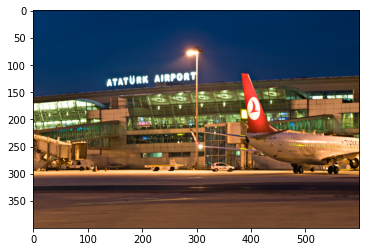

In [8]:
# Choices for the Model Architecture - values arbitrary
dense_layers = [1, 2, 3]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

# try different combinations!
# These for loops come from https://youtu.be/lV09_8432VA
for dense_layer in dense_layers:
    for size in layer_sizes:
        for conv in conv_layers:
            # name the combo
            NAME = (
                f'{conv}-conv-{size}-nodes' +
                f'-{dense_layer}-dense_layers' + 
                f'-{int(time.time())}'
            )
        # Instantiate TensorBoard to visualize model performance
        tensorboard = TensorBoard(log_dir=f'./Graph/{NAME}')
        # Instaniate model
        model = Sequential()
        # Add CNN layers
        add_conv_layer(model, size, True)
        for l in range(conv - 1):
            # add convolutional layers that come after the 1st
            add_conv_layer(model, size, False)
        # Flatten the data
        model.add(Flatten())
        # Add MLP Layers
        for l in range(dense_layer - 1):
            add_dense_layer(model, size, False)
        # add final MLP, for output
        add_dense_layer(model, 1, True)
        # Compile Model
        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy',
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall()])
        
        # Train the Model (using a generator!)
        # epoch is 5, batch_size is currently set to 20
        epochs, batch_size = 5, 20
        history = model.fit_generator(generator=data_gen(df_train, batch_size=batch_size),
                            steps_per_epoch=len(df_train['label']) // batch_size,
                            epochs=epochs,
                            validation_data=data_gen(df_test, batch_size=batch_size),
                            validation_steps=len(df_test['label']) // batch_size, 
                            callbacks=[tensorboard])

###  Finding Optimal Hyperparameters

Now, we'll find the optimal values for the hyperparameters using hyperas.

### Summarize the Model

In [5]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 1,198,850
Trainable params: 1,198,850
Non-trainable params: 0
____________________________________________

## Upsample the Minority Class

We need more fire!

## Data Augumentation

Let's add more variation to the dataset now, in order to make the model more robust!

## Model Evaluation

## Final Conclusions